## License Information
---

This file is distributed as part of `hvsrpy`, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_ and this notebook
---

`hvsrpy` is a Python package for performing horizontal-to-vertical spectral ratio
(HVSR) processing. `hvsrpy` was developed by Joseph P. Vantassel  with
contributions from Dana M. Brannon under the supervision
of Professor Brady R. Cox at The University of Texas at Austin.

If you use `hvsrpy` in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for `hvsrpy`, please use the citation tool on the `hvsrpy`
[archive](http://doi.org/10.5281/zenodo.3666956)._

The calculations to consider spatial variability included in `hvsrpy` and
showcased in this notebook were developed by Tianjian Cheng under the supervision of
Professor Brady R. Cox at The University of Texas at Austin and are detailed in
Cheng et al (2021). To recognize their original work please cite the follwing:

> Cheng, T., Hallal, M. M., Vantassel, J. P., and  Cox, B. R. (2021). "Estimating Unbiased Statistics for Fundamental Site Frequency Using Spatially Distributed HVSR Measurements and Voronoi Tessellation." Submitted to Journal of Geotechnical and Geoenvironmental Engineering.


## Getting Started
---
1. Install _hvsrpy_ and its dependencies, with `pip install hvsrpy`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Run the provided example for Warehouse 2 from CentrePort, NZ. Compare the results with those from Cheng et al. (2021). __(~5 minutes)__
3. Swap the provided .csv files (sensor information and boundary information) and repeat to develop spatial statistics for your site. __(~20 minutes)__

Happy Processing!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import cm

from hvsrpy import plottools
import hvsrpy

## Load Sensor Information
---

At a minimum the sensor information must include the relative x and y coordinates and an estimate of f0. It is strongly encouraged that an uncertainty estimate of f0 is also provided.

In [2]:
# File which includes hvsr statistical data.
fname = "sp_centreport.csv"
# Assumed distribution of the generators. "lognormal" is recommended.
dist_generators = "lognormal"
# Assumed/desired spatial distribution. "lognormal" is recommended.
dist_spatial = "lognormal"

df = pd.read_csv(fname)
coordinates = df.to_numpy(copy=True)[:, 0:2]
means = df.to_numpy(copy=True)[:, 2]
stddevs = df.to_numpy(copy=True)[:, 3]
df.head()

,x,y,mean,stddev
0,544.594606,432.890014,-0.411170,0.206193
1,587.352069,385.720914,-0.323445,0.163446
2,605.466471,300.679092,-0.236087,0.063194
3,521.008642,289.127687,-0.294558,0.156553
4,457.749280,314.640046,-0.417214,0.222720


## Create HvsrVault Object
---
The `HvsrVault` object stores all the Hvsr statistical data and their coordinates. Using an object allows different boundaries to be attempted on a single dataset.


In [3]:
vlt = hvsrpy.HvsrVault(coordinates, means, stddevs=stddevs)
print("HvsrVault object created successfully!")

HvsrVault object created successfully!


## Load Boundary Information

---
Specify unique x and y coordinates to define the Voronoi tesselations boundary.


In [4]:
df = pd.read_csv("sp_w2.csv")

boundary = df.to_numpy(copy=True)[:, 0:2]
df.head()

,x,y
0,323.402906,712.327227
1,514.514681,746.855647
2,555.973995,569.713082
3,372.155994,542.293165


## Apply Boundary
---

Apply boundary to `HvsrVault` and request spatial weights for declustered statistical analysis.


In [5]:
weights, valid_indices = vlt.spatial_weights(boundary, dc_method="voronoi")
valid_coordinates = vlt.coordinates[valid_indices,:]
vertices, indices = vlt.bounded_voronoi(boundary)

print(f"Number of Sensors Inside Boundary : {len(valid_indices)}")

Number of Sensors Inside Boundary : 8


## Plot Result
---

Statistics considering spatial variability:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",0.58,0.16
"Fundamental Site Period, T0",1.74,0.16


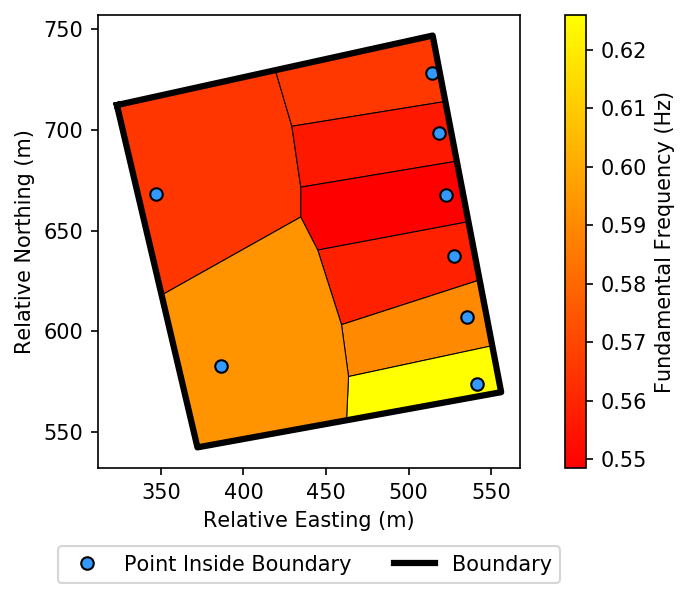

In [6]:
f0_mean, f0_stddev, f0s_realizations = hvsrpy.montecarlo_f0(means[valid_indices], stddevs[valid_indices], weights, nrealizations=1000, dist_generators=dist_generators, dist_spatial=dist_spatial)

if dist_spatial == "lognormal":    
    data = np.array([[f0_mean, f0_stddev],
                     [1/f0_mean, f0_stddev]])
    columns = ["Lognormal Median", "Lognormal Standard Deviation"]
elif dist_spatial == "normal":
    data = np.array([[f0_mean, f0_stddev],
                     [np.nan, np.nan]])
    columns = ["Mean", "Standard Deviation"]
else:
    raise ValueError(f"dist_spatial = {dist_spatial} not recognized.")

df = pd.DataFrame(data=data, columns=columns,
                       index=["Fundamental Site Frequency, f0",
                              "Fundamental Site Period, T0"])
print("Statistics considering spatial variability:")
display(df.round(2))

fig, axs = plt.subplots(ncols=2, figsize=(4.2,4), dpi=150, gridspec_kw=dict(width_ratios=(4,0.2)))
ax = axs[0]
ax.plot(valid_coordinates[:,0], valid_coordinates[:,1], color="#3399ff", linestyle="", marker="o", label="Point Inside Boundary", markeredgecolor="k")

closed_boundary = np.vstack((boundary, boundary[0,:]))
ax.plot(closed_boundary[:,0], closed_boundary[:,1], color="#000000", label="Boundary",  linewidth=3)

_data = means[valid_indices]
if dist_spatial == "lognormal":
    _data = np.exp(_data)
_min, _max = np.min(_data), np.max(_data)
norm = cm.colors.Normalize(vmin=_min, vmax=_max)
cmap = cm.autumn
mpl.colorbar.ColorbarBase(axs[1], cmap=cmap, norm=norm, label="Fundamental Frequency (Hz)")

for _dat, vertex in zip(_data, vertices):
    ax.fill(vertex[:, 0], vertex[:, 1], facecolor=mpl.colors.rgb2hex(cmap(norm(_dat))[:3]), edgecolor="k",   linewidth=0.5)

ax.set_xlabel("Relative Easting (m)")
ax.set_ylabel("Relative Northing (m)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

## Save Figure to File
---

In [7]:
figure_name_out = "example_hvsr_spatial.png"

fig.savefig(figure_name_out, dpi=300, bbox_inches='tight')
plt.close()
print("Figure saved successfully!")

Figure saved successfully!
